In [37]:
import pandas as pd
import numpy as np

from skopt.space import Real, Integer
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.optimizers import Adam

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

Neural Network Model for Hyper Parameter Tuning

In [38]:
def branin(X, Y):
    a = 1.0
    b = 5.1 / (4.0 * np.pi**2)
    c = 5.0 / np.pi
    r = 6.0
    s = 10.0
    t = 1.0 / (8.0 * np.pi)
    
    return a * (Y - b * X**2 + c * X - r)**2 + s * (1 - t) * np.cos(X) + s


In [39]:
# Random seed
np.random.seed(1)

# Number of observations to train the GP on before starting the active learning loop
pretrain_n = 10

# Standard deviation of simulated response
sim_stdev = 0.02

# Number of bayesian optimization iterations for calibrating simulation model
max_bo_iter = 150

# Random seed
r = np.random.default_rng(seed=2)

In [40]:
ran_err = lambda n, x: r.normal(0, x, n)
sim_err = lambda x, a, b: 0.1*(a - 4) * x + 0.05*(b + 3) * x**2 + r.normal(0, sim_stdev)

In [41]:
# Generate 10 random data points for 2 inputs (X, Y) within specified bounds
X = np.random.uniform(-5, 10, 10)
Y = np.random.uniform(0, 15, 10)

# Calculate the outputs using Branin and Currin functions
output1 = branin(X, Y) + ran_err(pretrain_n, 0.05)

# Generate Initial Dataset
df = pd.DataFrame({
    'x': X,
    'y': Y,
    'z': output1,
})


In [42]:
sim_eval = lambda x, y, a, b: branin(x, y) + sim_err(x, a, b)

In [43]:
from GPyOpt.methods import BayesianOptimization

def sim_all(x):
    df["a"] = x[0,0]
    df["b"] = x[0,1]
    df["sim_z"] = sim_eval(df["x"], df["y"], df["a"], df["b"])
    df["diff"] = df["z"] - df["sim_z"]
    return (df["diff"]**2).sum()

bo_domain = [{'name': 'a', 'type': 'continuous', 'domain': (2,5)},
          {'name': 'b', 'type': 'continuous', 'domain': (-4,-1)}]

# Calibrate the sim model using physical tests so far, update df["a"] and df["b"] with calibrated parameters
bo = BayesianOptimization(f=sim_all, domain=bo_domain, acquisition_type='EI')
bo.run_optimization(max_iter=max_bo_iter)
df["a"] = bo.x_opt[0]
df["b"] = bo.x_opt[1]
print(bo.x_opt)

[ 3.95963037 -3.00534208]


In [44]:
df

,x,y,z,a,b,sim_z,diff
0,1.255330,6.287918,17.324416,3.95963,-3.005342,17.327826,-0.003410
1,5.804867,10.278293,102.476533,3.95963,-3.005342,102.475702,0.000831
2,-4.998284,3.066784,211.938304,3.95963,-3.005342,211.944876,-0.006572
3,-0.465011,13.171762,59.468321,3.95963,-3.005342,59.605276,-0.136955
4,-2.798662,0.410814,123.265150,3.95963,-3.005342,123.181344,0.083806
5,-3.614921,10.057013,12.965302,3.95963,-3.005342,12.908120,0.057182
6,-2.206097,6.259572,19.342093,3.95963,-3.005342,19.368001,-0.025908
7,0.183411,8.380347,26.597489,3.95963,-3.005342,26.573760,0.023729
8,0.951512,2.105804,21.821530,3.95963,-3.005342,21.821209,0.000321
9,3.082251,2.971522,0.809324,3.95963,-3.005342,0.839898,-0.030574


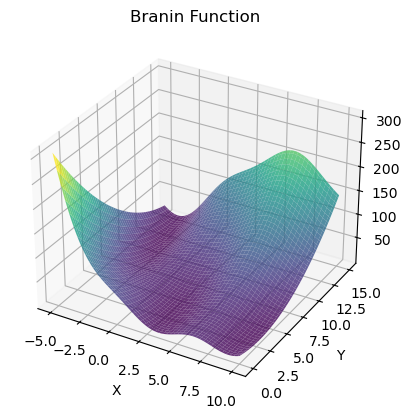

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create the grid of input values
x_range = np.linspace(-5, 10, 100)
y_range = np.linspace(0, 15, 100)
x_grid, y_grid = np.meshgrid(x_range, y_range)

# Evaluate function on grid
z_grid = branin(x_grid, y_grid)

# Create the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_grid, y_grid, z_grid, cmap='viridis', alpha=0.8)

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Branin Function')

# Show the plot
plt.show()

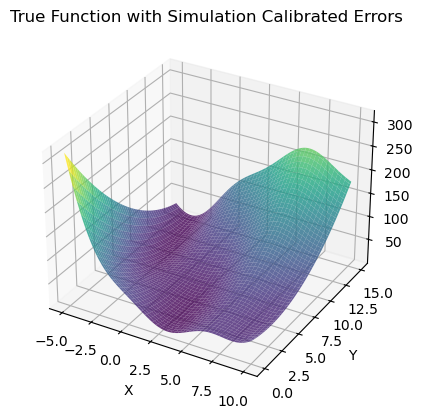

In [46]:
sim_z_grid = sim_eval(x_grid, y_grid, bo.x_opt[0], bo.x_opt[0])

# Create the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_grid, y_grid, sim_z_grid, cmap='viridis', alpha=0.8)

# Customize the plot
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('True Function with Simulation Calibrated Errors')

# Show the plot
plt.show()

In [47]:
# Define the hyperparameter space
hyp_space  = [
    Integer(2, 10, name='num_layers'), # Num of layers in the network (depth)
    Integer(50, 200, name='num_units'), # Num of neurons in each hidden layer (width)
    Real(0.00001, 0.1, prior='log-uniform', name='learning_rate'), # Steps size at each iteration 
    Real(0.0, 0.5, name='dropout_rate'), # Probability of droping out a neuron
    Integer(20, 150, name='batch_size'), # Num of samples per batch
    Integer(50, 200, name='epochs') # Num of epochs (iterations over the entire dataset) during training
]

# Defining the Neural Network Model
def NN_model(num_layers, num_units, learning_rate, dropout_rate):
    inputs = Input(shape=(2,))
    x = Dense(num_units, activation='relu', kernel_regularizer='l2')(inputs)
    for _ in range(num_layers - 1):
        x = Dense(num_units, activation='relu', kernel_regularizer='l2')(x)
        x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='linear')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

# Function for MC Dropout predictions
def mc_dropout_predictions(model, X, num_samples=100):
    predictions = np.zeros((num_samples, X.shape[0]))
    for i in range(num_samples):
        predictions[i, :] = model(X, training=True).numpy().flatten()
    prediction_mean = predictions.mean(axis=0)
    prediction_std = predictions.std(axis=0)
    return prediction_mean, prediction_std


In [48]:
def perform_iteration(df):
    # Define the objective function to minimize
    @use_named_args(hyp_space)
    def objective(**params):
        num_layers = params['num_layers']
        num_units = params['num_units']
        learning_rate = params['learning_rate']
        dropout_rate = params['dropout_rate']
        batch_size = params['batch_size']
        epochs = params['epochs']

        model = NN_model(num_layers, num_units, learning_rate, dropout_rate)
    
        # Define K-fold cross-validation
        kfold = KFold(n_splits=3)
        scores = []

        # Perform cross-validation
        for train_idx, val_idx in kfold.split(df[['x', 'y']]):
            X_train, X_val = df[['x', 'y']].iloc[train_idx], df[['x', 'y']].iloc[val_idx]
            y_train, y_val = df[['sim_z']].iloc[train_idx], df[['sim_z']].iloc[val_idx]

            # Standardize the features
            scaler_x = StandardScaler().fit(X_train)
            X_train_scaled = scaler_x.transform(X_train)
            X_val_scaled = scaler_x.transform(X_val)

            # Train the model
            model.fit(X_train_scaled, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

            # Evaluate the model
            score = model.evaluate(X_val_scaled, y_val, verbose=0)
            scores.append(score)
    
        return np.mean(scores)

    # Perform Bayesian optimization
    result = gp_minimize(objective, hyp_space, n_calls=50, random_state=0, acq_func='EI')

    # Output best hyperparameters from BayesOpt
    print("Best hyperparameters:")
    print("num_layers:", result.x[0])
    print("num_units:", result.x[1])
    print("learning_rate:", result.x[2])
    print("dropout_rate:", result.x[3])
    print("batch_size:", result.x[4])
    print("epochs:", result.x[5])

    # Train the model with the best hyperparameters on the entire dataset
    best_model = NN_model(
        num_layers=result.x[0],
        num_units=result.x[1],
        learning_rate=result.x[2],
        dropout_rate=result.x[3]
    )

    # Standardize the initial dataset
    scaler_x = StandardScaler().fit(df[['x', 'y']])
    X_scaled = scaler_x.transform(df[['x', 'y']])

    # Train the best model on the initial dataset
    best_model.fit(X_scaled, df[['z1']], epochs=result.x[5], batch_size=result.x[4], verbose=1)

    # Produce Meshgrid of results with C.I. 
    xy_grid = np.c_[x_grid.ravel(), y_grid.ravel()]
    pred_mean, pred_std = mc_dropout_predictions(best_model, xy_grid)

    # Identify 10 points with highest uncertainty to sample next
    num_new_points = 10
    high_uncertainty_indices = np.argsort(pred_std)[-num_new_points:]
    new_points = x_grid[high_uncertainty_indices]

    # Store new simualted points to validate and sample
    new_points_df = pd.DataFrame(new_points, columns=['x', 'y'])

    # Ploting mean predictions and confidence intervals
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Reshaping the predictions back to grid shape
    pred_mean_grid = pred_mean.reshape(x_grid.shape)
    pred_upper_grid = (pred_mean + 1.96 * pred_std).reshape(x_grid.shape)
    pred_lower_grid = (pred_mean - 1.96 * pred_std).reshape(x_grid.shape)

    mean_surface = ax.plot_surface(x_grid, y_grid, pred_mean_grid, color='blue', alpha=0.5, label='Mean Prediction')
    upper_surface = ax.plot_surface(x_grid, y_grid, pred_upper_grid, color='red', alpha=0.3, label='Upper Bound (95% CI)')
    lower_surface = ax.plot_surface(x_grid, y_grid, pred_lower_grid, color='green', alpha=0.3, label='Lower Bound (95% CI)')

    # Plot the high uncertainty points
    ax.scatter(new_points[:, 0], new_points[:, 1], color='black', marker='o', label='High Uncertainty Points')

    # Customize the plot
    ax.set_title('Neural Network Predictions with Confidence Intervals')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')

    # Legend
    legend_elements = [mean_surface, upper_surface, lower_surface]
    fig.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0.1, 0.9))

    # Show the plot
    plt.show()

    new_points_df


    # # Add validated data points to original data frame
    # df = pd.concat([df, validated_values], axis=0, ignore_index=True)
    # return df


In [50]:
df = perform_iteration(df)

KeyboardInterrupt: 

In [ ]:
df = perform_iteration(df)

Best hyperparameters:
num_layers: 6
num_units: 50
learning_rate: 0.0033636752977087387
dropout_rate: 0.0
batch_size: 20
epochs: 200
Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 4530.1802
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 4524.6714
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 4519.4985
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 4513.8628
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 4506.4292
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 4496.3960
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 4483.0376
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 4465.7891
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 4443.3838
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4413.8452
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 4375.2905
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 4325.0781
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step 

c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
     2 |       20 |      3 |  1.2123288533 |         ideal


c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
     3 |       30 |      4 |  0.0332015875 |         ideal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
     4 |       40 |      5 |  0.3394203150 |         nadir


c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
     5 |       50 |      7 |  0.1055694673 |         ideal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
     6 |       60 |      9 |  0.0397662725 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
     7 |       70 |     10 |  0.0252108510 |         ideal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
     8 |       80 |      7 |  0.0396264902 |         ideal


c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
     9 |       90 |      5 |  0.0477195733 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
    10 |      100 |      8 |  0.0160056679 |         ideal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
    11 |      110 |      9 |  0.4149474990 |         nadir
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
    12 |      120 |      9 |  0.0060393556 |         ideal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
    13 |      130 |     10 |  0.0042586552 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
    14 |      140 |     10 |  0.0020117580 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
    15 |      150 |     10 |  0.0121674845 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
    16 |      160 |     10 |  0.5716628340 |         nadir
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
    17 |      170 |     10 |  0.0372339131 |         ideal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
    18 |      180 |     10 |  0.0106905541 |         ideal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
    19 |      190 |     10 |  0.0151498870 |         ideal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
    20 |      200 |     10 |  0.0076681041 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
    21 |      210 |     10 |  0.0134192421 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
    22 |      220 |     10 |  0.0050777965 |         ideal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
    23 |      230 |     10 |  0.0112470095 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
    24 |      240 |     10 |  0.0127318994 |             f


c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
    25 |      250 |     10 |  0.0139788881 |         ideal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
    26 |      260 |     10 |  0.0079692704 |         ideal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
    27 |      270 |     10 |  0.0254964926 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
    28 |      280 |     10 |  0.0085942658 |         ideal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
    29 |      290 |     10 |  0.0015335781 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
    30 |      300 |     10 |  0.0196588228 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
    31 |      310 |     10 |  0.0000414499 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
    32 |      320 |     10 |  0.0010881624 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
    33 |      330 |     10 |  0.3891864784 |         nadir
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
    34 |      340 |     10 |  0.0251492087 |             f


c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
    35 |      350 |     10 |  0.0104481554 |         ideal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
    36 |      360 |     10 |  0.0100776206 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
    37 |      370 |     10 |  0.0092824114 |         nadir
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
    38 |      380 |     10 |  0.0407379916 |         nadir
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
    39 |      390 |     10 |  0.0094467337 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
    40 |      400 |     10 |  0.0170777347 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
    41 |      410 |     10 |  0.0251206825 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
    42 |      420 |     10 |  0.0226934663 |             f


c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
    43 |      430 |     10 |  0.0075987979 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
    44 |      440 |     10 |  0.0056325296 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
    45 |      450 |     10 |  0.0067653460 |         nadir
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
    46 |      460 |     10 |  0.0003318703 |             f


c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
    47 |      470 |     10 |  0.0125395030 |         nadir
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
    48 |      480 |     10 |  0.0147460925 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
    49 |      490 |     10 |  0.0639551452 |         nadir
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
    50 |      500 |     10 |  0.1047557620 |         nadir


c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
    51 |      510 |     10 |  0.0055760926 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
    52 |      520 |     10 |  0.0356152947 |         nadir


c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
    53 |      530 |     10 |  0.0044200939 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
    54 |      540 |     10 |  0.0118651456 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
    55 |      550 |     10 |  0.0221293083 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
    56 |      560 |     10 |  0.0228878527 |         nadir
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
    57 |      570 |     10 |  0.0124893637 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
    58 |      580 |     10 |  0.0190122085 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
    59 |      590 |     10 |  0.0122106439 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
    60 |      600 |     10 |  0.0069256579 |             f


c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
    61 |      610 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
    62 |      620 |     10 |  0.0134361231 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
    63 |      630 |     10 |  0.0098224864 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
    64 |      640 |     10 |  0.0262954953 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
    65 |      650 |     10 |  0.0089210744 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
    66 |      660 |     10 |  0.0020268399 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
    67 |      670 |     10 |  0.0155827350 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
    68 |      680 |     10 |  0.0112107618 |             f


c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
    69 |      690 |     10 |  0.0001892870 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
    70 |      700 |     10 |  0.0091288222 |         nadir
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
    71 |      710 |     10 |  0.0080706141 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
    72 |      720 |     10 |  0.0656963108 |         nadir
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
    73 |      730 |     10 |  0.0762718512 |         nadir
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
    74 |      740 |     10 |  0.0104441404 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
    75 |      750 |     10 |  0.0122382166 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
    76 |      760 |     10 |  0.0131487040 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
    77 |      770 |     10 |  0.0186650780 |         nadir
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
    78 |      780 |     10 |  0.0189119889 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
    79 |      790 |     10 |  0.0002781433 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
    80 |      800 |     10 |  0.0144270615 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
    81 |      810 |     10 |  0.0054299727 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
    82 |      820 |     10 |  0.0078672754 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
    83 |      830 |     10 |  0.0243652057 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
    84 |      840 |     10 |  0.0091931946 |             f


c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
    85 |      850 |     10 |  0.0037565816 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
    86 |      860 |     10 |  0.0243271781 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
    87 |      870 |     10 |  0.0136313705 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
    88 |      880 |     10 |  0.0074550962 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
    89 |      890 |     10 |  0.0174437471 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
    90 |      900 |     10 |  0.0001575001 |             f


c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
    91 |      910 |     10 |  0.0015122395 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
    92 |      920 |     10 |  0.0100127411 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
    93 |      930 |     10 |  0.0171524564 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
    94 |      940 |     10 |  0.0116915604 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
    95 |      950 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
    96 |      960 |     10 |  0.0174467425 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
    97 |      970 |     10 |  0.0070473457 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
    98 |      980 |     10 |  0.0095928236 |             f


c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
    99 |      990 |     10 |  0.0086519631 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
   100 |     1000 |     10 |  0.0218263717 |             f


c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 19.2519
Loss values stored in a DataFrame:
        loss
0  19.251862


In [ ]:
df

,x,y,z1,z2
0,3.882433,1.238570e+00,3.195042,4.241346
1,-1.263980,9.835033e+00,15.514625,-0.339727
2,8.634894,1.095936e+01,85.506584,0.719315
3,8.554015,9.808257e+00,67.331818,0.799645
4,4.355560,9.806835e+00,75.339826,0.657504
5,2.244323,3.239995e+00,4.036714,1.567934
6,6.593115,1.033280e+01,103.978458,0.707633
7,5.954446,2.335695e+00,20.606233,2.802407
8,-1.249144,1.212510e+01,28.523347,-0.274010
9,0.560863,4.200307e+00,19.029146,1.273153


In [ ]:
df = perform_iteration(df)

Best hyperparameters:
num_layers: 4
num_units: 50
learning_rate: 0.1
dropout_rate: 0.0
batch_size: 20
epochs: 200
Epoch 1/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2920.6270
Epoch 2/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1349.3102 
Epoch 3/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2225.3838 
Epoch 4/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 922.9809 
Epoch 5/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 433.7600 
Epoch 6/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 597.8166 
Epoch 7/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 201.1163 
Epoch 8/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 158.2903 
Epoch 9/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 344.5016 
Epoch 10/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 193.6522 
Epoch 11/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 115.5328 
Epoch 12/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 184.5484 
Epoch 13/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 142.2662
Epoch 14/2

c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
     2 |       20 |      4 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
     3 |       30 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
     4 |       40 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
     5 |       50 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
     6 |       60 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
     7 |       70 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
     8 |       80 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
     9 |       90 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
    10 |      100 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
    11 |      110 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


    12 |      120 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
    13 |      130 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


    14 |      140 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
    15 |      150 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
    16 |      160 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
    17 |      170 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


    18 |      180 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
    19 |      190 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
    20 |      200 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
    21 |      210 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
    22 |      220 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
    23 |      230 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


    24 |      240 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
    25 |      250 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


    26 |      260 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
    27 |      270 |     10 |  0.000000E+00 |             f


c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
    28 |      280 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
    29 |      290 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
    30 |      300 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
    31 |      310 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
    32 |      320 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
    33 |      330 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


    34 |      340 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
    35 |      350 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


    36 |      360 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
    37 |      370 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


    38 |      380 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
    39 |      390 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


    40 |      400 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
    41 |      410 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


    42 |      420 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
    43 |      430 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


    44 |      440 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
    45 |      450 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


    46 |      460 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
    47 |      470 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
    48 |      480 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
    49 |      490 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


    50 |      500 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
    51 |      510 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


    52 |      520 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
    53 |      530 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


    54 |      540 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
    55 |      550 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


    56 |      560 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
    57 |      570 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
    58 |      580 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
    59 |      590 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
    60 |      600 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
    61 |      610 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
    62 |      620 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
    63 |      630 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
    64 |      640 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
    65 |      650 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


    66 |      660 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
    67 |      670 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
    68 |      680 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
    69 |      690 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


    70 |      700 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
    71 |      710 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


    72 |      720 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
    73 |      730 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


    74 |      740 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
    75 |      750 |     10 |  0.000000E+00 |             f


c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
    76 |      760 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


    77 |      770 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
    78 |      780 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
    79 |      790 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
    80 |      800 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
    81 |      810 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
    82 |      820 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
    83 |      830 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
    84 |      840 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


    85 |      850 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
    86 |      860 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


    87 |      870 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
    88 |      880 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


    89 |      890 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
    90 |      900 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


    91 |      910 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
    92 |      920 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


    93 |      930 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
    94 |      940 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


    95 |      950 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
    96 |      960 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


    97 |      970 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
    98 |      980 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


    99 |      990 |     10 |  0.000000E+00 |             f
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
   100 |     1000 |     10 |  0.000000E+00 |             f


c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\Simon\anaconda3\envs\research\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 218156.2500
Loss values stored in a DataFrame:
        loss
0  218156.25


In [ ]:
df

,x,y,z1,z2
0,3.882433,1.238570e+00,3.195042,4.241346
1,-1.263980,9.835033e+00,15.514625,-0.339727
2,8.634894,1.095936e+01,85.506584,0.719315
3,8.554015,9.808257e+00,67.331818,0.799645
4,4.355560,9.806835e+00,75.339826,0.657504
5,2.244323,3.239995e+00,4.036714,1.567934
6,6.593115,1.033280e+01,103.978458,0.707633
7,5.954446,2.335695e+00,20.606233,2.802407
8,-1.249144,1.212510e+01,28.523347,-0.274010
9,0.560863,4.200307e+00,19.029146,1.273153
